In [1]:
# Import necessary libraries
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum
jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)

N = 10 # number of Monte Carlo samples


n = 256 # Dimensionality of the state space for KS model
observation_interval = 5  # Interval at which observations are made
dt = 0.25  # Time step for the KS model

num_steps = 250  # Number of time steps
J0 = 0
n = 40   # Number of state variables
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.03 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)

n_ensemble = 5
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q



# State initialization
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)

state_transition_function = ks_model.step
ks_step = Partial(state_transition_function)
key = random.PRNGKey(0)
jacobian_function = jacrev(ks_step, argnums=0)
jac_func = Partial(jacobian_function)


observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, ks_step, observation_interval)

In [2]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_localization_matrix(n, radius)
    pred_states, pred_covariances, states, covariances = ensrf_steps(model, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    ensemble_mean_pred = jnp.mean(pred_states, axis=-1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean_pred, pred_covariances, ensemble_mean, covariances, n, model, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost

In [4]:
inflation = 1.5  # Fixed starting value for inflation
radius_opt = 1.0
alpha = 1e-4  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
localization_matrix = generate_localization_matrix(n, radius_opt)



In [5]:
ensemble_init.shape

(40, 5)

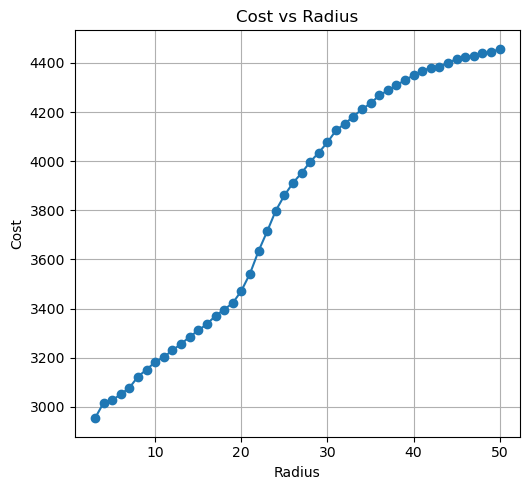

In [6]:
radius_range = jnp.arange(3, 51, 1)  # from 3 to 40 with step size 1
inflation = 1.05
radius_values = []
cost_values = []

for radius_opt in radius_range:
    key, subkey = random.split(key)

    cost = var_cost(radius_opt, inflation, ks_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    radius_values.append(radius_opt)
    cost_values.append(cost)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(radius_values, cost_values, label='Cost', marker='o')
plt.title('Cost vs Radius')
plt.xlabel('Radius')
plt.ylabel('Cost')
plt.grid(True)


plt.tight_layout()
plt.show()


In [7]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import random
from mpl_toolkits.mplot3d import Axes3D


ensemble_sizes = [5, 10, 20, 40]
radius_range = jnp.arange(1, 41, 2)
inflation_range = jnp.linspace(1.01, 1.9, 20)

results = []

for n_ensemble in ensemble_sizes:
    ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T
    cost_values = []
    for radius_opt in radius_range:
        for infl in inflation_range:
            key, subkey = random.split(key)
            cost = var_cost(radius_opt, infl, ks_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)  
            cost_values.append((radius_opt, infl, cost))
    
    results.append((n_ensemble, jnp.array(cost_values)))


import pickle


with open('ks_ensemble_data.pkl', 'wb') as file:
    pickle.dump(results, file)

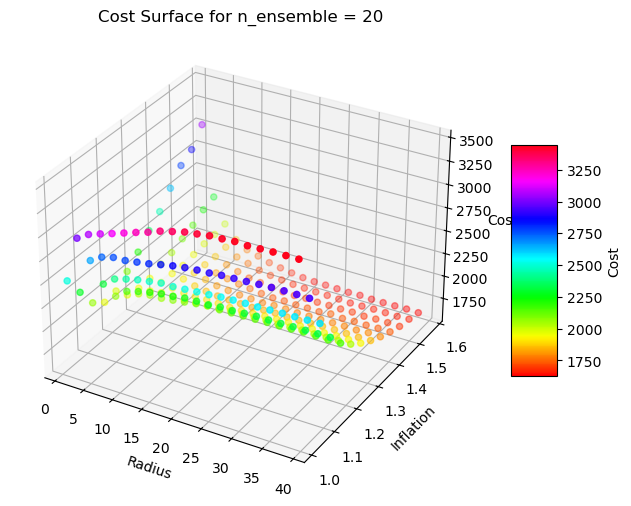

In [8]:
import pickle
with open('ks_ensemble_data.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

n_ensemble, data = loaded_results[2] 
radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]
mask = (inflation_values < 1.6)
radius_values1 = radius_values[mask]
inflation_values1 = inflation_values[mask]
cost_values1 = cost_values[mask]


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using extracted data
scat = ax.scatter(radius_values1, inflation_values1, cost_values1, c=cost_values1, cmap='hsv', marker='o')
ax.set_xlabel('Radius')
ax.set_ylabel('Inflation')
ax.set_zlabel('Cost')
ax.set_title(f'Cost Surface for n_ensemble = {n_ensemble}')

# Adding a color bar to interpret the cost values more easily
color_bar = fig.colorbar(scat, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Cost')

plt.show()

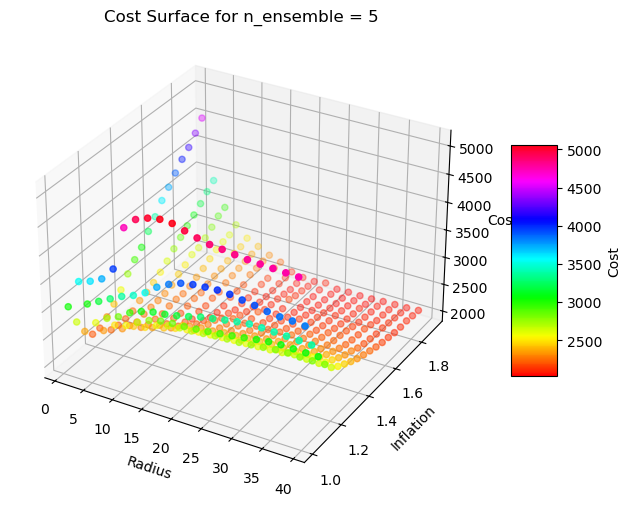

In [12]:
n_ensemble, data = loaded_results[0] 
radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using extracted data
scat = ax.scatter(radius_values, inflation_values, cost_values, c=cost_values, cmap='hsv', marker='o')
ax.set_xlabel('Radius')
ax.set_ylabel('Inflation')
ax.set_zlabel('Cost')
ax.set_title(f'Cost Surface for n_ensemble = {n_ensemble}')

# Adding a color bar to interpret the cost values more easily
color_bar = fig.colorbar(scat, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Cost')

plt.show()

In [46]:
base_m, base_C, base_K = kalman_filter_process(l96_step, jac_func, m0, C0, observations, H, Q, R)


In [47]:
import properscoring
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random


var_cost_grad = grad(var_cost, argnums=0)

inflation = 1.05  # Fixed starting value for inflation
radius_opt = 16.0
alpha = 1e-1  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 10  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
radii = []
rmses=[]
true_div = []


for i in tqdm(range(100)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_radius = var_cost_grad(radius_opt, inflation, l96_step, ensemble_init, observations, H, Q, R, subkey, num_steps, J0)
    radius_opt -= alpha * grad_radius  # Update inflation parameter
    radii.append(radius_opt)
    localization_matrix = generate_gc_localization_matrix(n, radius_opt)

    states, _ = ensrf_steps(l96_step, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    print(radius_opt, grad_radius, rmse)
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, predicted_states[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t 
    true_div.append(total_kl_divergence / num_steps)
    

  0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'generate_gc_localization_matrix' is not defined

In [ ]:
plt.plot(radii)

In [ ]:
plt.plot(rmses)

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting the RMSE and CRPS on the primary y-axis
color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('RMSE / CRPS', color=color)
ln1 = ax1.plot(rmses, label='RMSE', color='tab:orange', linestyle='-')
ln2 = ax1.plot(crpss, label='CRPS', color='tab:red', linestyle='--')
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin y-axis for the inflation parameter
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Localization Radius', color=color)
ln3 = ax2.plot(radii, label='Radius', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

# Combine legends from both axes
lns = ln1 + ln2 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

plt.title('RMSE, CRPS, and Radius Parameter over Iterations')
plt.show()


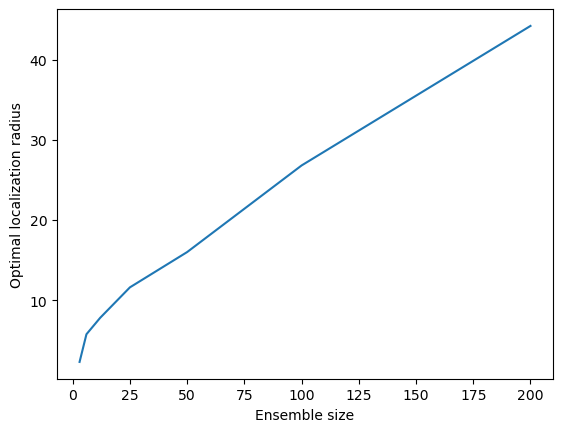

In [13]:
plt.plot([3, 6, 12, 25, 50, 100, 200], [2.3, 5.75, 7.8, 11.6, 16, 26.8, 44.2])
plt.xlabel("Ensemble size")
plt.ylabel("Optimal localization radius")
plt.savefig("localization_radii.pdf")